In [13]:
# Importación de liberarías utilizadas a lo largo del Notebook.
# ETL y EDA. 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker


# Modelo. Selección y ajustes.
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

#### **1. EDA.**

In [14]:
# Lectura del dataset.
path = r"C:\Users\HP\Downloads\data.csv"
df = pd.read_csv(path, dtype={0:'str'})

df.head(1)

,fullVisitorID,visitNumber,date,bounces,hits,pageviews,timeOnSite,transactionRevenue,transactions,source,channelGrouping,browser,deviceCategory,country,city
0,8533875475515924645,1,20170205,1.0,1,1.0,NaN,NaN,NaN,(direct),Organic Search,Chrome,desktop,Australia,Sydney


In [15]:
# Inspección general del dataset: cantidad de registros, columnas, nulos y tipo de datos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392892 entries, 0 to 392891
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fullVisitorID       392892 non-null  object 
 1   visitNumber         392892 non-null  int64  
 2   date                392892 non-null  int64  
 3   bounces             195964 non-null  float64
 4   hits                392892 non-null  int64  
 5   pageviews           392856 non-null  float64
 6   timeOnSite          196399 non-null  float64
 7   transactionRevenue  5277 non-null    float64
 8   transactions        5277 non-null    float64
 9   source              392892 non-null  object 
 10  channelGrouping     392892 non-null  object 
 11  browser             392892 non-null  object 
 12  deviceCategory      392892 non-null  object 
 13  country             392892 non-null  object 
 14  city                392892 non-null  object 
dtypes: float64(5), int64(3), object(7)

In [16]:
# Se analizan posibles valores duplicados.
df[df.duplicated()]

,fullVisitorID,visitNumber,date,bounces,hits,pageviews,timeOnSite,transactionRevenue,transactions,source,channelGrouping,browser,deviceCategory,country,city


In [17]:
# Se adecua formato fecha y se generan variable temporal mensual.
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['month'] = df['date'].dt.month

# Se genera variable converted, que indica que en un determinado registro llevó a cabo una transacción.
df['converted'] = np.where(df['transactions'] > 0, 'converted', 'not_converted')

# Se inputa valor cero a registros que presentan nulos.
df['bounces'] = df['bounces'].fillna(0).astype(int)
df['pageviews'] = df['pageviews'].fillna(0).astype(int)
df['transactionRevenue'] = df['transactionRevenue'].fillna(0).astype(float)
df['transactions'] = df['transactions'].fillna(0).astype(float)
df['timeOnSite'] = df['timeOnSite'].fillna(0).astype(float)

# Se genera variable timeOnSite en minutos.
df['timeOnSite_m'] = (df['timeOnSite'] / 60).astype(float)

<div class="admonition tip alert alert-info" style="padding: 15px; border-radius: 8px;">
  <p class="first admonition-title" style="font-weight: bold; font-size: 1.1em; margin-bottom: 10px;">
    Comentarios iniciales
  </p>
  <p class="last" style="margin: 0;">
    Considerando los tres objetivos propuestos, a saber:
  </p>
  <ul style="margin-top: 5px; margin-bottom: 10px;">
    <li><strong>a)</strong> Predecir la cantidad de transacciones del mes siguiente;</li>
    <li><strong>b)</strong> Estimar la probabilidad de que un usuario compre (haga una transacción);</li>
    <li><strong>c)</strong> Agrupar a los usuarios de acuerdo a sus características.</li>
  </ul>
  <p style="margin: 0;">
    Se selecciona para su estudio el punto <strong>b</strong>, dado que:
  </p>
  <ul style="margin-top: 5px; margin-bottom: 10px;">
    <li>Para el punto <strong>a</strong>, se considera escaso el período temporal de seis meses para tal fin (aunque pueden realizarse análisis como proyecciones exploratorias de tendencias o modelos simples de forecasting).</li>
    <li>El punto <strong>c</strong> requiere un conocimiento más profundo del negocio (aunque variables categóricas como país o tipo de dispositivo pueden ser utilizadas para realizar una segmentación básica).</li>
  </ul>
  <p style="margin: 0;">
    No obstante ello, el punto <strong>b</strong> se considera muy interesante.
  </p>
</div>

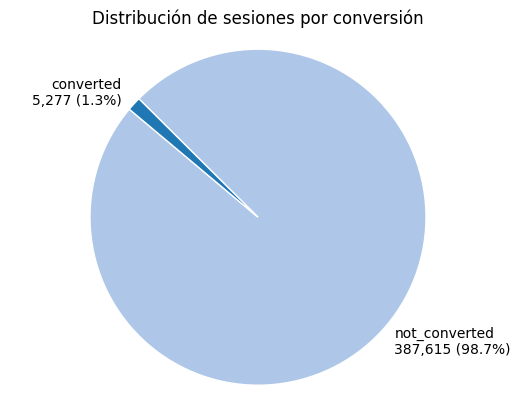

In [18]:
# Como primer paso, se analiza la proporción de registros con transacciones en el dataset.
c = df['converted'].value_counts()
plt.pie(c, labels=[f"{i}\n{v:,} ({v/c.sum()*100:.1f}%)" for i, v in c.items()],
        colors=['#aec7e8', '#1f77b4'], startangle=140, wedgeprops={'edgecolor': 'white'})
plt.title('Distribución de sesiones por conversión')
plt.axis('equal')
plt.show()

In [19]:
# Como segundo paso, se analiza si existen relaciones entre la variable converted y resto de variables de forma general.

# Función para obtener las tres primeras frecuencias en variables categóricas.
top3 = lambda s: s.value_counts().head(3).index.tolist()

df.groupby('converted').agg({col: 'median' for col in ['visitNumber', 'bounces', 'hits', 'pageviews', 'timeOnSite_m']} | {col: top3 for col in ['channelGrouping', 'browser', 'deviceCategory', 'country']}).reset_index()


,converted,visitNumber,bounces,hits,pageviews,timeOnSite_m,channelGrouping,browser,deviceCategory,country
0,converted,2.0,0.0,26.0,21.0,12.45,"[Referral, Organic Search, Direct]","[Chrome, Safari, Firefox]","[desktop, mobile, tablet]","[United States, Canada, Taiwan]"
1,not_converted,1.0,1.0,1.0,1.0,0.00,"[Organic Search, Direct, Social]","[Chrome, Safari, Firefox]","[desktop, mobile, tablet]","[United States, India, United Kingdom]"


In [20]:
# Como tercer paso del proceso EDA, se generan nuevos features.

# Ratio de interacciones por minuto en la sesión.
df['hits_per_minute'] = df['hits'] / df['timeOnSite_m']

# Tiempo promedio en segundos por página vista.
df['seconds_per_pageview'] = df['timeOnSite'] / df['pageviews']

# Indicador binario: 1 si la sesión fue un sábado o domingo, 0 en caso contrario.
df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)

# Indicador binario: 1 si el usuario realizó al menos una compra en algún momento.
user_converted = df.groupby('fullVisitorID')['transactions'].sum() > 0
df['has_ever_converted'] = df['fullVisitorID'].map(user_converted).astype(int)

# Días entre la primera y la última visita del usuario.
visit_range = df.groupby('fullVisitorID')['date'].agg(['min', 'max'])
visit_range['days_between_first_last_visit'] = (visit_range['max'] - visit_range['min']).dt.days
df['days_between_first_last_visit'] = df['fullVisitorID'].map(visit_range['days_between_first_last_visit'])

# Indicador binario: 1 si la sesión es la primera visita del usuario, 0 en caso contrario.
df['is_first_visit'] = (df['visitNumber'] == 1).astype(int)

# Reemplazo de valores infinitos o nulos por 0 para evitar errores en el modelado.
df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

<div class="admonition tip alert alert-info" style="padding: 15px; border-radius: 8px;">
  <p class="first admonition-title" style="font-weight: bold; font-size: 1.1em; margin-bottom: 10px;">
    Consideraciones sobre EDA
  </p>
  <p style="margin: 0;">
    Para obtener probabilidades de compra por parte de un usuario, es necesario identificar variables (features) con potencial explicativo. A partir del análisis exploratorio realizado, pueden destacarse los siguientes puntos:
  </p>
  <ul style="margin-top: 5px; margin-bottom: 10px;">
    <li>
      El dataset presenta un <strong>fuerte desbalance de clases</strong>, como era de esperarse, con gran cantidad de sesiones sin transacciones (98,7%). Este desequilibrio impondrá dos desafíos: por un lado, reduce la cantidad de ejemplos para estimar los factores que explican una sesión con compra; por otro, afecta la forma en que debe evaluarse la performance de cualquier modelo. En este contexto, <strong>métricas como accuracy resultarán poco informativas</strong>, y deben priorizarse otras como <strong>precision</strong> y <strong>recall</strong>. En particular, se opta aquí por utilizar <strong>recall</strong> como métrica principal, ya que permite medir qué proporción de las compras reales son correctamente identificadas por el modelo.
    </li>
    <li>
      Se observan diferencias marcadas entre clases (compra vs. no compra) en variables como <strong>número de visitas</strong>, <strong>cantidad de interacciones (hits)</strong> y <strong>tiempo de sesión</strong>, siendo estos valores significativamente mayores en sesiones con transacción. En contraste, <strong>las variables categóricas como país, navegador o tipo de dispositivo no muestran una discriminación evidente</strong> entre clases y no serán consideradas (aunque serán relevantes para cualquier modelo de segmentación).
    </li>
    <li>
      Por último, se propone la <strong>generación de nuevas variables derivadas</strong> (feature engineering) que refuercen las anteriores, como por ejemplo: promedio de tiempo por página, ratio de hits por minuto, o si corresponde a una primera visita por parte del usuario, lo cual podría aportar mayor poder predictivo al modelo.
    </li>
    <li>
      Como comentario adicional, se consideró la posibilidad de utilizar solo aquellos registros que presenten <strong>bounces</strong> distintos de 1, dado que se entiende que estos son los únicos que potencialmente registren una transacción. Sin embargo, el hecho de que en producción esos registros formen parte de la información a analizar, se prefirió no sesgar el modelo.
    </li>
  </ul>
</div>

##### **1.1. MODELO.**

In [21]:
# Selección de features e identificación de features y target.
features = ['bounces', 'hits_per_minute', 'seconds_per_pageview', 'is_weekend', 'has_ever_converted', 'days_between_first_last_visit', 'is_first_visit']
X = df[features]
df['converted_n'] = (df['converted'] == 'converted').astype(int)
y = df['converted_n']

# Preprocesamiento.
preprocessor = ColumnTransformer([('num', StandardScaler(), X.columns)])

# División en train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# ---------- Logistic Regression ----------
print("Estimando modelo: Logistic Regression")

pipe_lr = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

# Entrenamiento y predicción.
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

# Performance en test.
cm_lr = confusion_matrix(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)

print("Matriz de confusión (Logistic Regression):\n", cm_lr)
print("Precisión:", round(precision_lr, 3))
print("Recall:", round(recall_lr, 3))
print("-" * 50)

# ---------- Random Forest Classifier ----------
print("Estimando modelo: Random Forest Classifier")

pipe_rf = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Entrenamiento y predicción.
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

# Performance en test.
cm_rf = confusion_matrix(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

print("Matriz de confusión (Random Forest):\n", cm_rf)
print("Precisión:", round(precision_rf, 3))
print("Recall:", round(recall_rf, 3))

Estimando modelo: Logistic Regression
Matriz de confusión (Logistic Regression):
 [[95366  1538]
 [    0  1319]]
Precisión: 0.462
Recall: 1.0
--------------------------------------------------
Estimando modelo: Random Forest Classifier
Matriz de confusión (Random Forest):
 [[96607   297]
 [  464   855]]
Precisión: 0.742
Recall: 0.648


In [22]:
# Validación cruzada.
cv_results = cross_validate(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='recall',
    return_train_score=True
)

# Mostrar resultados por fold.
print("Recall en test por fold:", cv_results['test_score'])
print("Recall en train por fold:", cv_results['train_score'])
print("Recall promedio (test):", round(cv_results['test_score'].mean(), 3))

Recall en test por fold: [1.         1.         1.         0.99873737 0.99873578]
Recall en train por fold: [0.99936849 0.99936829 0.99968414 1.         0.99936849]
Recall promedio (test): 0.999


In [23]:
# Grid de hiperparámetros
param_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# GridSearch con validación cruzada, optimizando recall
grid_search = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

# Ajuste sobre el set de entrenamiento
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejores hiperparámetros:")
print(grid_search.best_params_)

# Evaluación final sobre el test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Matriz de confusión (modelo con hiperparámetros óptimos):\n", cm)
print("Precisión:", round(precision, 3))
print("Recall:", round(recall, 3))

Mejores hiperparámetros:
{'clf__C': 0.001}
Matriz de confusión (modelo con hiperparámetros óptimos):
 [[94486  2418]
 [    0  1319]]
Precisión: 0.353
Recall: 1.0


In [24]:
# Coeficientes del mejor modelo para definir ecuación de probabilidad de compra.
coefs = best_model.named_steps['clf'].coef_[0]
intercept = best_model.named_steps['clf'].intercept_[0]
features = best_model.named_steps['preprocess'].transformers_[0][2]

# Mostrar coeficientes con sus nombres
for f, c in zip(features, coefs):
    print(f"{f}: {c:.4f}")
print(f"Intercepto: {intercept:.4f}")

bounces: -1.3105
hits_per_minute: -0.7531
seconds_per_pageview: 0.0116
is_weekend: 0.0209
has_ever_converted: 1.7754
days_between_first_last_visit: -0.1813
is_first_visit: 0.1084
Intercepto: -6.2809


$$
P(\text{compra}) = \frac{1}{1 + \exp\left(-z\right)}
$$

donde:

$$
z = -6.2809 
- 1.3105 \cdot \text{bounces}
- 0.7531 \cdot \text{hits\_per\_minute}
+ 0.0116 \cdot \text{seconds\_per\_pageview}
+ 0.0209 \cdot \text{is\_weekend}
+ 1.7754 \cdot \text{has\_ever\_converted}
- 0.1813 \cdot \text{days\_between\_first\_last\_visit}
+ 0.1084 \cdot \text{is\_first\_visit}
$$

<div class="admonition tip alert alert-info" style="padding: 15px; border-radius: 8px;">
  <p class="first admonition-title" style="font-weight: bold; font-size: 1.1em; margin-bottom: 10px;">
    Resultados
  </p>
  <p style="margin: 0;">
    Para abordar la tarea de clasificación binaria se utilizaron dos modelos: <strong>RandomForestClassifier</strong> y <strong>LogisticRegression</strong>. El único preprocesamiento aplicado fue un <strong>escalado estándar (StandardScaler)</strong>, ya que modelos lineales como la regresión logística suelen presentar un mejor rendimiento cuando las variables están normalizadas. Esto se debe a que <strong>LogisticRegression utiliza un solver para maximizar una función de verosimilitud</strong>, y su convergencia suele ser más eficiente cuando los features están en escalas comparables. También se experimentó con la incorporación de <strong>SMOTE</strong> para balancear las clases, aunque los resultados obtenidos no mostraron mejoras significativas.
  </p>
  <p style="margin-top: 10px; margin-bottom: 0;">
    En términos de resultados, se destaca una mejor performance de <strong>LogisticRegression</strong> en la métrica de <strong>recall</strong>. Si bien la <strong>precisión</strong> obtenida fue baja, ello refleja el clásico <em>trade-off</em> entre estas dos métricas: al priorizar recall, se identifican más casos positivos reales, pero también aumentan los falsos positivos.
  </p>
  <p style="margin-top: 10px; margin-bottom: 0;">
    Además, se analizaron los efectos de modificar el <strong>threshold de decisión</strong>, que por defecto es 0.5. Se observó que al incrementar este valor, el <strong>recall disminuye</strong> mientras que <strong>la precisión aumenta</strong>.
  </p>
  <p style="margin-top: 10px; margin-bottom: 0;">
    Respecto a la capacidad de generalización, <strong>LogisticRegression mostró un comportamiento consistente entre el conjunto de entrenamiento y prueba</strong>, lo cual fue confirmado mediante validación cruzada (<em>cross-validation</em>). No se evidencian signos de sobreajuste (<em>overfitting</em>).
  </p>
  <p style="margin-top: 10px;">
    Por último, se analizaron los coeficientes estimados del modelo logístico para entender cuáles variables tienen mayor impacto en la predicción de compra. Se destacan tres variables:
    <ul style="margin-top: 5px;">
      <li><strong>has_ever_converted</strong>: coeficiente positivo elevado, indica que usuarios con historial de compra previa tienen considerablemente mayor probabilidad de volver a comprar.</li>
      <li><strong>bounces</strong>: coeficiente negativo fuerte, sugiere que sesiones sin interacción están fuertemente asociadas a no conversión.</li>
      <li><strong>hits_per_minute</strong>: coeficiente negativo, lo que podría interpretarse como comportamiento impulsivo o superficial no asociado a compra.</li>
    </ul>
  </p>
</div>

#### **2. REPORTE.**

<div class="admonition tip alert alert-success" style="padding: 15px; border-radius: 8px;">
  <p class="first admonition-title" style="font-weight: bold; font-size: 1.1em; margin-bottom: 10px;">
    Informe de Resultados
  </p>
  <p style="margin: 0;">
    En base a datos provenientes de mediciones efectuadas en el sitio Merchandise Store de Google a lo largo de un período de seis meses, se ha intentado conocer el comportamiento de los usuarios en dicho sitio. Particularmente, se ha avanzado sobre el objetivo de estimar la probabilidad de que un usuario realice una transacción durante su sesión. Para tal fin se ha divido el problema en dos: i) en primer lugar, explorar la fuente de información con la que se cuenta, comprendiendo el contenido y significado de cada variable, al tiempo de intuir posibles relaciones entre las mismas y la variable a predecir; ii) en segundo lugar, iterar en busca de un modelo que se ajuste correctamente al problema a resolver (clasificación binaria). 
  </p>
  <p style="margin-top: 10px; margin-bottom: 0;">
    Durante la primer etapa de exploración se detectó un <strong>fuerte desbalance en la variable objetivo</strong>: la gran mayoría de las sesiones no terminan en una transacción. Por este motivo, se optó por priorizar métricas que evalúen la capacidad del modelo de identificar correctamente los casos positivos, como el recall. Para la comprensión del dataset, se analizaron las distribuciones de las <strong>variables numéricas</strong> diferenciando entre sesiones con y sin compra, identificando comportamientos distintivos en variables como la cantidad de hits, el tiempo en el sitio y la cantidad de páginas vistas. Estas fueron incluidas luego en el modelo junto con otras variables generadas a partir de las mismas, como el ratio de hits por minuto o un indicador de si el usuario ya había comprado previamente. No se consideraron variables categóricas (como el país, el navegador o la fuente de tráfico) debido a la alta cardinalidad de algunas de ellas, a la falta de diferencias claras (posible poder predictivo) entre clases del feature, y a que el objetivo era mantener el modelo simple y fácilmente interpretable.
  </p>
  <p style="margin-top: 10px;">
    Para el objetivo de clasificación binaria, se entrenaron dos modelos: un Random Forest y una <strong>Regresión Logística</strong>. La regresión logística fue la que mostró mejor equilibrio entre simplicidad y rendimiento, sin evidencias de sobreajuste (overfitting) durante la validación cruzada. Como se comentaba previamente, la métrica principal fue el recall, dado que se buscaba maximizar la detección de sesiones que terminan en compra, aunque a costa de disminuir la precisión (o a costa de aumentar los falsos positivos). Una ventaja adicional del modelo logístico es que permite interpretar fácilmente el efecto de cada variable a través de sus coeficientes estimados, lo que a su vez permite identificar qué variables incrementan la probabilidad de conversión (coeficientes positivos) y cuáles la reducen (coeficientes negativos). En cuanto a su implementación, el modelo puede aplicarse en producción para asignar a cada sesión una probabilidad de compra y activar campañas personalizadas en tiempo real, por ejemplo. Sin embargo, es necesario aclarar aquí que para que el modelo mantenga su rendimiento, es fundamental monitorear que las distribuciones de las variables de entrada no se desvíen significativamente respecto a las observadas durante el entrenamiento. Por último, a nuestro entender el proyecto puede ampliarse o enriquecerse incluyendo información (nuevo features) sobre las páginas visitadas y los artículos consultados o comprados, lo que permitiría construir modelos más ricos y específicos.
  </p>
</div>